<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/intermittent%20TS/Intermittent_Time_Series_using_AutoArima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intermittent/zero‑inflated demand notes
------------------------------------------
* Intermittent series have many zeros (e.g., closed days) and sporadic positive bursts.
* ARIMA‑type models can still work with careful preprocessing, but specialized methods (Croston, SBA, TSB) also exist.
* In this script, we set predictions to 0 on days when the store is closed (`Open==0`) **after** inverse‑transforming the forecast.
* Exogenous covariates (holidays, open/closed flags, promos) can help AutoARIMA choose better orders and improve accuracy.

Links:
------------------------------------------
* Darts Documentation: https://unit8co.github.io/darts/index.html
* Darts AutoArima: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.sf_auto_arima.html

## Libraries

https://unit8co.github.io/darts/

In [1]:
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import AutoARIMA
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import root_mean_squared_error
import numpy as np

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/Intermittent Time Series

/content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/Intermittent Time Series


## Data Loading

Data Source: https://www.kaggle.com/c/rossmann-store-sales

In [6]:
df = pd.read_csv('train.csv')
df.head()

/tmp/ipython-input-189615863.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
# Preview info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


# Data Prep

In [7]:
# Retain Store 1 only
df = df[df['Store'] == 1]

# Rename Sales to y and Date to ds
df = df.rename(columns={'Sales': 'y', 'Date': 'ds'})

# Change ds from object to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Set ds as index
df.set_index('ds', inplace = True)

# Set index to Daily
df = df.asfreq('D')

print(df.head())
print(df.info())
print(df.index)

            Store  DayOfWeek     y  Customers  Open  Promo StateHoliday  \
ds                                                                        
2013-01-01      1          2     0          0     0      0            a   
2013-01-02      1          3  5530        668     1      0            0   
2013-01-03      1          4  4327        578     1      0            0   
2013-01-04      1          5  4486        619     1      0            0   
2013-01-05      1          6  4997        635     1      0            0   

            SchoolHoliday  
ds                         
2013-01-01              1  
2013-01-02              1  
2013-01-03              1  
2013-01-04              1  
2013-01-05              1  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek    

Upon checking `StateHoliday`, unique values are a, b, c, 0 and 0. Also the data type is an object.

In [10]:
# Check StateHoliday
df['StateHoliday'].value_counts()

,count
StateHoliday,
0,915
1,27


In [9]:
# Change StateHoliday to binary. 1 if a/b/c. 0 if 0/0
df['StateHoliday'] = df['StateHoliday'].apply(lambda x: 1 if x in ['a', 'b', 'c'] else 0)
df['StateHoliday'].value_counts()

,count
StateHoliday,
0,915
1,27


In [11]:
# Check SchoolHoliday
df['SchoolHoliday'].value_counts()


,count
SchoolHoliday,
0,749
1,193


In [12]:
# Drop unneeded columns
df.drop(columns = ['Store', 'DayOfWeek', 'Customers'], inplace = True)
df.head()

,y,Open,Promo,StateHoliday,SchoolHoliday
ds,,,,,
2013-01-01,0,0,0,1,1
2013-01-02,5530,1,0,0,1
2013-01-03,4327,1,0,0,1
2013-01-04,4486,1,0,0,1
2013-01-05,4997,1,0,0,1


# EDA

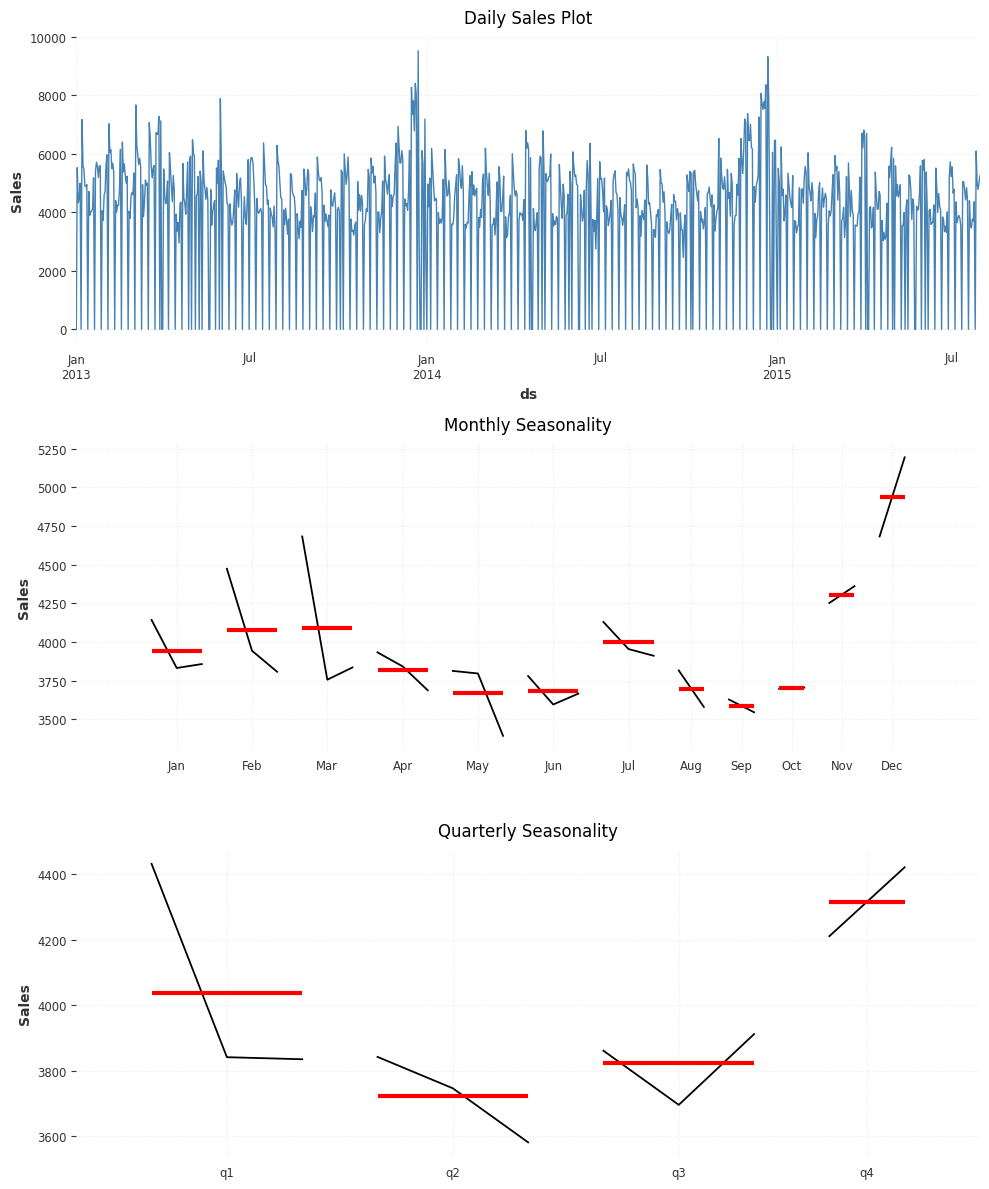

In [30]:
# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df['y'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Daily Sales Plot', fontsize=12, pad=10)
ax1.set_ylabel('Sales', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)

# Monthly Seasonality Plot
month_plot(df['y'].resample('ME').mean(), ylabel='Demand', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Sales', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df['y'].resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Sales', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Weekly Seasonality'}, xlabel='Day of the Week', ylabel='y'>

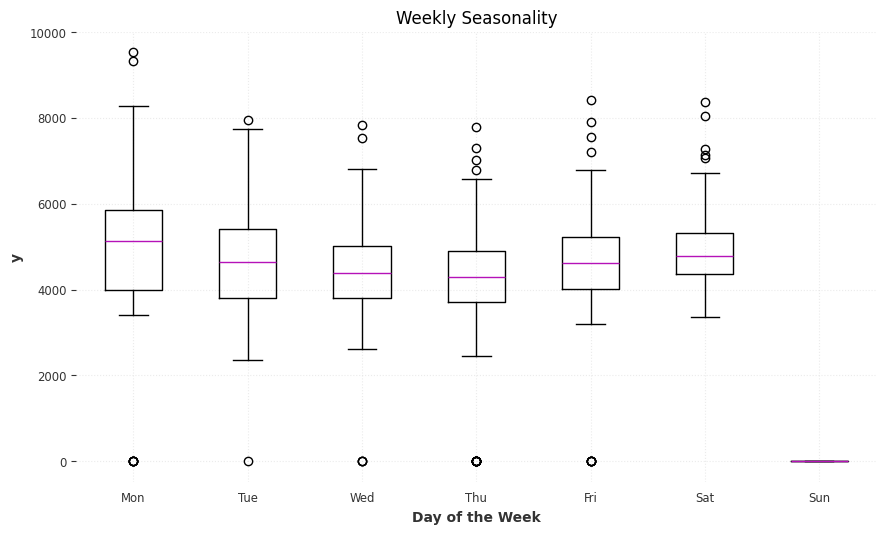

In [25]:
def week_plot(ts, ax=None):
    """
    Creates a plot to visualize weekly seasonality.

    Parameters
    ----------
    ts : pd.Series
        The time series data with a DatetimeIndex.
    ax : matplotlib.axes.Axes, optional
        The axes to plot on. If None, a new figure is created.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Ensure the index is a DatetimeIndex
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise TypeError("The index of the Series must be a DatetimeIndex.")

    # Add 'weekday' as a new column and convert to DataFrame
    df_temp = ts.to_frame() # Convert Series to DataFrame
    df_temp['weekday'] = df_temp.index.dayofweek

    # Plot the weekly seasonality
    df_temp.boxplot(column=ts.name, by='weekday', ax=ax) # Now df_temp is a DataFrame

    # Set the labels for days of the week
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.set_title('Weekly Seasonality')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel(ts.name)
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.suptitle('')  # Suppress the automatic boxplot title

    return ax

week_plot(df['y'], ax= None)

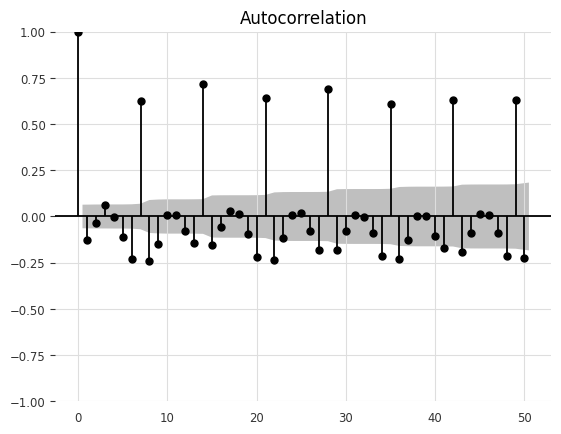

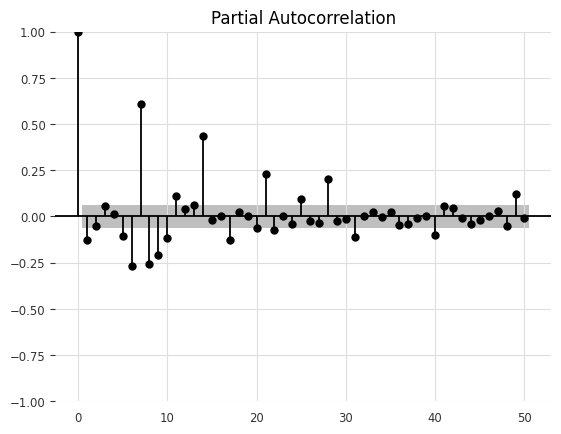

In [29]:
# Plot the ACF and PACF (diagnostics only)
# Strong spikes at lag 7 often indicate weekly seasonality.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.y, lags = 50)
plot_pacf(df.y, lags = 50)
plt.show()

# Darts Data Prep

Darts tips for this workflow
----------------------------
* `TimeSeries.from_dataframe` requires a DateTimeIndex or a time column; you are already using an index.
* Scale the **target** to stabilize estimation; keep covariates on original scale unless needed.
* When evaluating, always inverse‑transform predictions back to the original scale.
* `historical_forecasts` with `retrain=True` re‑fits the model at each fold using all data up to that point (mimics production rolling retrain).

In [31]:
# Isolate the y and transform to TimeSeries
target = TimeSeries.from_dataframe(df[['y']])

In [32]:
# Isolate the Covariates
# Everything except y is treated as future covariates
covariates = TimeSeries.from_dataframe(df.drop(columns = 'y'))
covariates

<TimeSeries (ds: 942, component: 4, sample: 1)> Size: 30kB
array([[[0.],
        [0.],
        [1.],
        [1.]],

       [[1.],
        [0.],
        [0.],
        [1.]],

       [[1.],
        [0.],
        [0.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [1.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 8kB 2013-01-01 2013-01-02 ... 2015-07-31
  * component  (component) object 32B 'Open' 'Promo' ... 'SchoolHoliday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [33]:
# Scale the target. No need to scale the covariates as it is already in 0 and 1.
# Scaling helps AutoARIMA's internal estimation; we inverse‑transform for metrics.
scaler = Scaler()
target_scaled = scaler.fit_transform(target)
target_scaled

<TimeSeries (ds: 942, component: 1, sample: 1)> Size: 8kB
array([[[0.        ]],

       [[0.58039463]],

       [[0.45413518]],

       [[0.47082284]],

       [[0.52445424]],

       [[0.        ]],

       [[0.75314861]],

       [[0.58564232]],

       [[0.57420235]],

       [[0.51343409]],

...

       [[0.36356003]],

       [[0.39557095]],

       [[0.38895886]],

       [[0.45801847]],

       [[0.        ]],

       [[0.64042821]],

       [[0.52592359]],

       [[0.50188917]],

       [[0.52686818]],

       [[0.55237196]]])
Coordinates:
  * ds         (ds) datetime64[ns] 8kB 2013-01-01 2013-01-02 ... 2015-07-31
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# AutoArima

https://otexts.com/fpp2/the-forecast-package-in-r.html

In [34]:
model = AutoARIMA(seasonal = True,
                  season_length = 7, #Captures Weekly Seasonality
                  stepwise = True) #searches a subset of models for speed
model.fit(target_scaled, future_covariates=covariates)

AutoARIMA(add_encoders=None, quantiles=None, random_state=None, seasonal=True, season_length=7, stepwise=True)

# Cross Validation

In [35]:
# Define the Forecast Horizon
forecast_horizon = 30

In [36]:
# Compute the starting index for 12 rolling folds of length `forecast_horizon`
df.shape[0] - 12* forecast_horizon

582

In [37]:
# Perform Cross-Validation with Rolling Forecast
# * `historical_forecasts` rolls through time, each time training up to a cutoff
#   and forecasting `forecast_horizon` steps ahead.
# * `stride=forecast_horizon` jumps by non‑overlapping windows for 12 folds.
# * `retrain=True` ensures re‑estimation on each fold (production‑like).
cv = model.historical_forecasts(
    series = target_scaled,                         # df[y]
    future_covariates = covariates,                 #covariates
    forecast_horizon = forecast_horizon,            #sets how many steps ahead the model will forecast in each iteration
    stride = forecast_horizon,                      #how many steps the forecasting window moves forward in each iteration. Setting it equal to forecast_horizon means the windows are non-overlapping
    start = df.shape[0] - forecast_horizon * 12,
    retrain = True,                                 #ensures re‑estimation on each fold
    last_points_only = False)

In [ ]:
# Evaluate each fold
rmse_cv = []

for i in range(len(cv)):

  # Inspect the output
  # Inverse‑transform back to the original sales scale
  predictions = TimeSeries.to_series(scaler.inverse_transform(cv[i]))

  # Set the predictions to 0 when the store is closed
  # This enforces the business rule that sales must be zero when `Open==0`.
  predictions[df['Open'] == 0] = 0

  # Get the first and last index and retrieve actuals
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = df.loc[start:end, 'y']

  # Calculate the RMSE
  rmse = root_mean_squared_error(actuals, predictions)
  rmse_cv.append(rmse)

# Display the results
print(f'RMSE: {np.mean(rmse_cv):.2f}')

RMSE: 792.25


In [38]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE for each fold
mape_cv = []
for i in range(len(cv)):
    # Inverse-transform predictions back to original scale
    predictions = TimeSeries.to_series(scaler.inverse_transform(cv[i]))

    # Set predictions to 0 when the store is closed
    predictions[df['Open'] == 0] = 0

    # Get actuals for the current fold's time range
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.loc[start:end, 'y']

    # Calculate MAPE
    mape = mean_absolute_percentage_error(actuals, predictions)
    mape_cv.append(mape)

# Display the average MAPE
print(f'MAPE: {np.mean(mape_cv):.2f}')

MAPE: 0.13


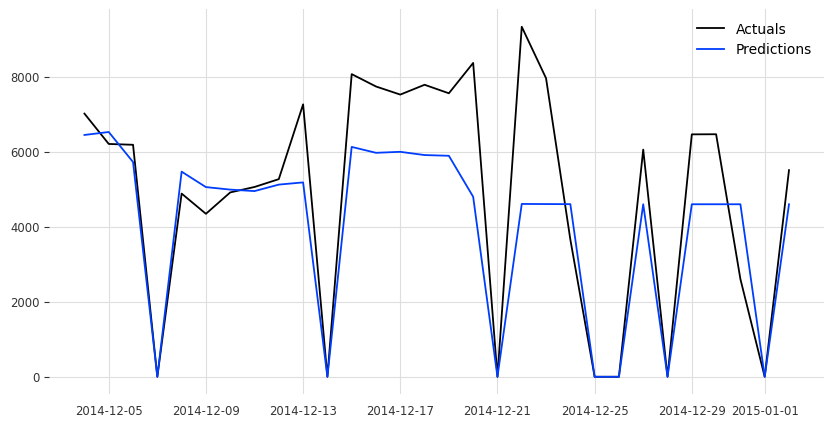

In [ ]:
# Visualize the CV[4] against the actuals (unchanged logic)
predictions = TimeSeries.to_series(scaler.inverse_transform(cv[4]))

# Set the predictions to 0 when the store is closed
predictions[df['Open'] == 0] = 0

# Get the first and last index and retrieve actuals
start = predictions.index.min()
end = predictions.index.max()
actuals = df.loc[start:end, 'y']

plt.figure(figsize = (10, 5))
plt.plot(actuals, label = 'Actuals')
plt.plot(predictions, label = 'Predictions')
plt.legend(loc = "best")
plt.show()

# Challenge prompts
----------------
1. Predict the future: fit on all available history and forecast next 30 days.
2. Try exogenous variants: include additional known future covariates (e.g., Promo calendar).
3. Compare with SARIMAX (statsmodels) + parameter tuning on the same folds.
4. Try intermittent‑demand specialists (Croston/TSB) available in Darts and compare.